# Model training

In this notebook we start from preprocessed data (see [01-data-prep.ipynb](01-data-prep.ipynb)) and train a ML model for predicting trips duration.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np

import xgboost as xg

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, median_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, FunctionTransformer

# Local
PATH_TO_SRC = Path('../src').resolve()
sys.path.append(PATH_TO_SRC.as_posix())
import lib_model  # nopep8

PATH_TO_DATA = Path('../data').resolve()
PATH_TO_RES = Path('./results').resolve()
PATH_TO_FIGS = Path('./figures').resolve()

os.makedirs(PATH_TO_RES, exist_ok=True)
os.makedirs(PATH_TO_FIGS, exist_ok=True)

RANDOM_STATE = 78239

In [3]:
# ---------------------------------------------------------------- Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots
import plotly.express as px

plotly_show_opts = dict(height=400, width=800)
plotly_show_opts = dict(renderer='png', height=400, width=800)
pd_plot_optns = dict(backend='plotly')

# Data Load

In [4]:
# Preprocess dataset
df = pd.read_csv(PATH_TO_DATA / 'training-data.csv')

# categorise kpis
cols_features = [
    'avg_duration_prev_7days', 'HPCP',
    'is_registered', 'dow_sin',
    'dow_cos', 'has_trace',
]
col_target = 'duration_min'

# Data Cleaning

Here we clean data for training.

- Trips happening in periods for which weather data are unavailable are not used for training.
    - In [01-data-prep.ipynb](01-data-prep.ipynb), a feature `has_precip_data` had been built with the intent of keeping these records for training (and allowing the model to learn to use weather information, when available).
    - However, this did not lead to more accurate models, hence the records have been dropped.
    - Note that the model is still trained on approx 1 mil data points, which is sufficient for this POC with less than 10 features.

- ~10% of records do not have a `avg_duration_prev_7days`. These is for trips that took place within 7 days from opening a new hub. These records can be removed because as:
    - There is still plenty of data.
    - Trips happening just after a hub was opened (or moved) may be longer than usual (as users need to learn new routes), hence representing an outlier.

- Some trips have unrealisticly long durations (either negative, or too large). This was noted already in [00-dataset-overview.ipynb](00-dataset-overview.ipynb). 
    - For simplicity, these records have be removed from training/EDA.
    - In future development, we may still want to ignore these from traning, but we may want to evaluate how the model performs when predicting the duration of these trips.

In [5]:
# remove data points collected when weather data were not available
mask_keep = df['has_precip_data'] == 1
print(f'Dropping {sum(~mask_keep)}/{len(df)} records without weather data.')
df = df[mask_keep]

# Some  unrealistically long trips
duration_min_up_bound = df['duration_min'].quantile(.95)
mask_keep = (df['duration_min'] > 0) & (df['duration_min'] <= duration_min_up_bound)
print(f'Dropping {sum(~mask_keep)}/{len(df)} records with abnormal trip duration over'
      f'{duration_min_up_bound: .2f}.')
df = df[mask_keep].reset_index(drop=True)

# - Dropping records without `avg_duration_prev_7days`.
mask_keep = ~df['avg_duration_prev_7days'].isna()
print(f'Dropping {sum(~mask_keep)}/{len(df)} records without `avg_duration_prev_7days`.')
df = df[mask_keep].reset_index()

Dropping 536384/1579011 records without weather data.
Dropping 54239/1042627 records with abnormal trip duration over 49.00.
Dropping 11537/988388 records without `avg_duration_prev_7days`.


In [6]:
df[cols_features + [col_target]].describe()

,avg_duration_prev_7days,HPCP,is_registered,dow_sin,dow_cos,has_trace,duration_min
count,976851.000000,976851.000000,976851.000000,976851.000000,976851.000000,976851.000000,976851.000000
mean,14.523821,0.001614,0.707085,0.037384,-0.013500,0.055130,13.079254
std,3.394628,0.019833,0.455100,0.697852,0.715139,0.228234,8.740721
min,5.219444,0.000000,0.000000,-0.974928,-0.900969,0.000000,0.016667
25%,12.108235,0.000000,0.000000,-0.781831,-0.900969,0.000000,6.683333
50%,14.000533,0.000000,1.000000,0.000000,-0.222521,0.000000,10.933333
75%,16.273438,0.000000,1.000000,0.781831,0.623490,0.000000,17.383333
max,55.086957,1.330000,1.000000,0.974928,1.000000,1.000000,49.000000


In [7]:
df.head()

,index,seq_id,start_date,strt_statn,end_statn,duration_min,is_registered,avg_duration_prev_7days,dow_sin,dow_cos,HPCP,has_trace,has_precip_data
0,3665,5127,2011-08-04 00:04:00,10.0,41.0,6.533333,0,20.699565,0.433884,-0.900969,0.0,0,1
1,3666,5129,2011-08-04 00:11:00,16.0,15.0,27.650000,0,19.235160,0.433884,-0.900969,0.0,0,1
2,3667,5131,2011-08-04 00:21:00,21.0,14.0,12.666667,0,24.493803,0.433884,-0.900969,0.0,0,1
3,3668,5132,2011-08-04 00:21:00,21.0,14.0,12.250000,0,24.493803,0.433884,-0.900969,0.0,0,1
4,3669,5133,2011-08-04 00:25:00,47.0,36.0,12.550000,0,28.081597,0.433884,-0.900969,0.0,0,1


## Transformation Pipeline

- A log transform is chosen for the `HPCP` variables. 
    - The transformed distribution has a wider spread, but remains far from normal, which may limit the performance of algorithms that require normally distributed variables.
    - The main limitation remains the fact that most records have no rain, hence ML models may struggle to pick this pattern.
        - In future iterations, consider oversampling the records with rain during training.

- A standard scaler is adequate for `avg_duration_prev_7days`.

- No normalisation is needed for the binary features `is_registered` and `has_trace`.

- No normalisation is required for `dow_sin` and `dow_cos`, which already have values in range $[-1,1]$.

In [8]:
# add scaler/column transformer
scaler = ColumnTransformer([
    ('standard_sc', StandardScaler(), ['avg_duration_prev_7days',]),
    ('log_sc', FunctionTransformer(np.log1p, validate=True), ['HPCP',]),
    ('no_scaling', 'passthrough', ['is_registered', 'dow_sin', 'dow_cos', 'has_trace',])
], remainder='passthrough')

scaler.fit(df[cols_features])

df_transf = pd.DataFrame(
    scaler.transform(df[cols_features]),
    columns=cols_features
)

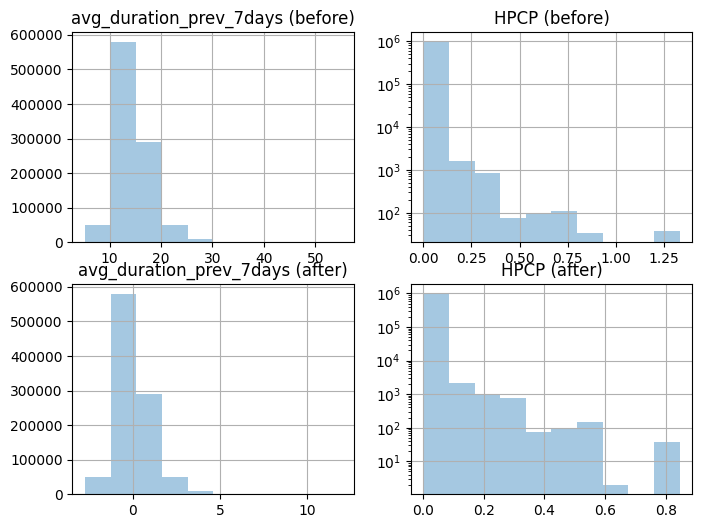

In [9]:
cols_plot = ['avg_duration_prev_7days', 'HPCP']
fig = plt.figure('Impact of Transformations', (4*len(cols_plot), 6))
Ax = fig.subplots(2, len(cols_plot), squeeze=False)
for ii, col in enumerate(cols_plot):
    # before
    Ax[0, ii].set_title(col + ' (before)')
    df[col].hist(ax=Ax[0, ii], alpha=.4)
    # after
    Ax[1, ii].set_title(col + ' (after)')
    df_transf[col].hist(ax=Ax[1, ii], alpha=.4)

    if col == 'HPCP':
        for ax in Ax[:, ii]:
            ax.set_yscale('log')

# Getting ready for training

A variety of metrics are used to evaluate the model's performance. In the discussion below, we will primarily focus on the following:

**MAE (Mean Absolute Error)** and **MEDAE (Median Absolute Error)**: These metrics are highly interpretable, as they quantify the model's error in the same units as the target variable (in this case, minutes), making them intuitive and easy to understand.

**R<sup>2</sup> (Coefficient of Determination)**: This metric measures the proportion of variance in the target variable that is explained by the model. It serves as an indicator of whether the model is capturing patterns in the data or not.


To quickly test a few different models, we will use a simple train/test split. For the final model selection, a grid search with k-fold cross validation will be used instead.


> Note: The target variable has not been scaled, as the trip duration values are relatively small, ensuring the stability of most algorithms used in this proof of concept (POC). However, for testing and verification purposes, we have also prepared a scaled version of the target variable. This scaled version was used to confirm that no accuracy was lost during training.

In [10]:
# show function used for evaluating the models.
lib_model.get_scores?

# split in train/test set
df_train, df_test, y_train, y_test = train_test_split(
    df[cols_features], df[col_target], test_size=0.2, random_state=RANDOM_STATE)

# For testing, we also prepare a scaled version of the target variable
scaler_target = StandardScaler()
scaler_target.fit(df[col_target].values.reshape(-1,1))
y_train_scaled = scaler_target.transform( y_train.values.reshape(-1,1))
y_test_scaled = scaler_target.transform( y_test.values.reshape(-1,1))

Signature: lib_model.get_scores(y_true, y_pred, model_id: str = None) -> pandas.core.series.Series
Docstring: Produce a set of scores suitable for regression models.
File:      ~/git/bikehub-model/src/lib_model.py
Type:      function

# Baseline Model

This is an engineering model that predicts each trip to last as the average (over the previous 7 days) of the trips starting from the same station. Note that:

- The model requires no training, as the `avg_duration_prev_7days` is precomputed as part of the data preparation.
- In deployment, this feature would need to be computed every day for each station.
- For new station, the average across all trips across alll stations can be used.

In [11]:
scores = lib_model.get_scores(df[col_target], df['avg_duration_prev_7days'], 'baseline')
scores

,mae,medae,mse,rmse,r2
id,,,,,
baseline,6.97332,6.059701,77.210943,8.786976,-0.010613


The model has a null R2, which indicates that computing the average for each station does add any benefit to simply using the average across all trips (and stations).

The MAE and MEDAE is farily large, when considering that the median trip duration is just below 11 min.

# Linear regressor model

In [12]:
regressor_lin = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE)
model_lin = Pipeline([('scaler', scaler), ('regressor', regressor_lin)])

# train/evaluate
model_lin.fit(df_train, y_train)
y_pred = model_lin.predict(df_test)
scores_lin = lib_model.get_scores(y_test, y_pred, 'linear')

# # train/evaluate (using scaled target variable)
# model_lin.fit(df_train, y_train_scaled)
# y_pred = scaler_target.inverse_transform(model_lin.predict(df_test).reshape(-1,1))
# scores_lin = lib_model.get_scores(y_test, y_pred)

scores = pd.concat([scores, scores_lin]).drop_duplicates()
scores

,mae,medae,mse,rmse,r2
id,,,,,
baseline,6.97332,6.059701,77.210943,8.786976,-0.010613
linear,6.01272,4.998586,61.279283,7.828109,0.196843


The model is not hypertuned, but reduces the error of approx. 1 min. The MAE is still large (>50% when scaled to the median duration).

The R2 grows to about 20%. This is very low, but proves the model is picking up some patterns.

An analysis of the coefficients of the regressor highlights that:
- The model has a large intercept. Note that the intercept is dimensional (and mesured in minutes), as the target variable has not been scaled. 
- `avg_duration_prev_7days` has a positive coefficient, hence the model will predict larger trips duration when the average trip value is large. The impact of this term is, however, little when compare to the intercept.
- The `is_registered` flag is the most important variable in the model: almost 6 minutes are removed to the trip duration of registered users.
- The model fails completely to capture the impact of weather (`HPCP` and `has_trace` have null coefficients).
    - This can be part due to the low number of trips with rain
    - But also to how these features have been engineered (these represent not the precipitation during the trip, but during the hour before the trip started).

In [13]:
pd.DataFrame(data=regressor_lin.coef_.reshape(1, len(cols_features)), columns=cols_features).T

,0
avg_duration_prev_7days,1.250424
HPCP,-0.000000
is_registered,-5.697105
dow_sin,-0.849717
dow_cos,0.061553
has_trace,-0.000000


In [14]:
regressor_lin.intercept_

np.float64(17.139712199131015)

# XGBoost nonlinear regressor

The linear model above failed to capture some (expected) nonlinear relations - especially between precipitation volume, `HPCP` and `has_trace`, and the `is_registered` variable.

A nonlinear model is hence showcased here. We preferred a tree based model as these tend to be more robust to scaling, which may help dealing with the `HPCP` feature.

In [15]:
regressor_xgb = xg.XGBRegressor(
    objective='reg:absoluteerror',
    n_estimators=20,
    max_depth=10,
    learning_rate=.01,        # Values in range [0.1,1] produced best results here.
    subsample=0.75,           # Data subsampling.
    gamma=1,                  # Min. split loss (fight overfitting).
    min_child_weight=0,       # Min. sum of weights required in child node.
    # colsample_bytree=0.8,   # Feature subsampling
    # reg_alpha=0.1,          # L1 regularization
    # reg_lambda=1.0,         # L2 regularization
    seed=RANDOM_STATE,
)

model_xgb = Pipeline([('scaler', scaler), ('regressor', regressor_xgb)])
model_xgb.fit(df_train, y_train)
y_pred = model_xgb.predict(df_test[cols_features])
scores_xgb = lib_model.get_scores(y_test, y_pred, 'xgb')

scores = pd.concat([scores, scores_xgb]).drop_duplicates()
scores

,mae,medae,mse,rmse,r2
id,,,,,
baseline,6.973320,6.059701,77.210943,8.786976,-0.010613
linear,6.012720,4.998586,61.279283,7.828109,0.196843
xgb,6.290666,4.736873,75.207603,8.672232,0.014291


The XGBoost model has a bad R2, but reduces both the MAE and MEDAE (which is expected as the chose as we optimised training against the absolute error).

Tree based models can require extensive fine tuning to perform well - this is done next.

# Grid Search

A randomised grid search is used here to fine tune the XGB parameters. For the sake of this POC, the search is limited to a small number of iterations.

In [16]:
param_grid = dict(
    regressor__n_estimators=[10, 20, 50, 100],
    regressor__max_depth=[5, 10, 20],
    regressor__learning_rate=[0.01, 0.1, 0.3, 0.5],
    regressor__subsample=[0.75, 1.0],
    regressor__gamma=[0, 1, 5],
    regressor__min_child_weight=[1, 3, 5],
)
scoring_dict = dict(
    mae=make_scorer(mean_absolute_error),
    medae=make_scorer(median_absolute_error),
    mse=make_scorer(mean_squared_error),
    rmse=make_scorer(root_mean_squared_error),
    r2=make_scorer(r2_score),
)
gs = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_grid,
    scoring=scoring_dict,
    refit='mae',
    n_iter=60,
    cv=4,
    n_jobs=-1,
    verbose=1,
)

In [17]:
RUN_GRID_SEARCH = False

if RUN_GRID_SEARCH:
    _ = gs.fit(df[cols_features], df[col_target].values)
    df_gs_res = lib_model.from_gridsearch_to_df(gs, scoring_dict)
    df_gs_res.to_csv(PATH_TO_RES/'grid-search-xgb.csv', index=False)
else:
    df_gs_res = pd.read_csv(PATH_TO_RES/'grid-search-xgb.csv')

df_gs_res.sort_values('medae_avg', ascending=True).head(10)

,regressor__subsample,regressor__n_estimators,regressor__min_child_weight,regressor__max_depth,regressor__learning_rate,regressor__gamma,mae_avg,mae_std,medae_avg,medae_std,mse_avg,mse_std,rmse_avg,rmse_std,r2_avg,r2_std
0,1.00,20,3,10,0.5,5,5.825235,0.138487,4.280010,0.138800,63.533734,2.462354,7.969284,0.155726,0.164112,0.043671
6,1.00,100,5,10,0.5,5,5.825255,0.138371,4.280266,0.138917,63.536074,2.462585,7.969430,0.155741,0.164082,0.043651
54,1.00,50,1,10,0.3,5,5.822636,0.137183,4.282092,0.137204,63.492596,2.458873,7.966705,0.155584,0.164678,0.043136
42,1.00,50,5,5,0.1,5,5.821112,0.137162,4.283319,0.133208,63.481565,2.459522,7.966011,0.155661,0.164831,0.043000
5,1.00,10,5,5,0.5,1,5.822663,0.137702,4.286610,0.139904,63.486891,2.448866,7.966360,0.154932,0.164723,0.043613
32,1.00,100,5,5,0.5,1,5.824977,0.138888,4.288087,0.134545,63.544963,2.492994,7.969950,0.157659,0.164011,0.043092
22,0.75,50,3,5,0.5,5,5.822746,0.137836,4.289591,0.132586,63.516206,2.456083,7.968191,0.155355,0.164365,0.043156
40,0.75,100,5,5,0.5,5,5.823186,0.137851,4.291731,0.130865,63.517215,2.457844,7.968252,0.155475,0.164356,0.043107
52,0.75,100,1,5,0.5,0,5.833353,0.139491,4.292037,0.132927,63.701230,2.496196,7.979748,0.157646,0.161949,0.043280
9,0.75,100,3,5,0.5,0,5.832594,0.139364,4.292736,0.128594,63.695877,2.494969,7.979414,0.157576,0.162007,0.043524


## Optimal model analysis

In [18]:
regressor_xgb_opt = xg.XGBRegressor(
    objective='reg:absoluteerror',
    n_estimators=20,
    max_depth=10,
    learning_rate=.5,        # Values in range [0.1,1] produced best results here.
    subsample=1.0,           # Data subsampling.
    gamma=5,                  # Min. split loss (fight overfitting).
    min_child_weight=3,       # Min. sum of weights required in child node.
    seed=RANDOM_STATE,
)

model_xgb_opt = Pipeline([('scaler', scaler), ('regressor', regressor_xgb_opt)])
model_xgb_opt.fit(df_train, y_train)
y_pred = model_xgb_opt.predict(df_test[cols_features])
scores_xgb_opt = lib_model.get_scores(y_test, y_pred, 'xgb_opt')

# verify overfitting: evaluate model on training set
scores_xgb_opt_train = lib_model.get_scores(y_train, model_xgb_opt.predict(
    df_train[cols_features]),
    'xgb_opt (train set)')

scores = pd.concat([scores, scores_xgb_opt, scores_xgb_opt_train]).drop_duplicates()
scores

,mae,medae,mse,rmse,r2
id,,,,,
baseline,6.973320,6.059701,77.210943,8.786976,-0.010613
linear,6.012720,4.998586,61.279283,7.828109,0.196843
xgb,6.290666,4.736873,75.207603,8.672232,0.014291
xgb_opt,5.791251,4.223472,62.928149,7.932726,0.175232
xgb_opt (train set),5.791722,4.217322,63.078389,7.942190,0.174644


The grid search, managed to improve the performance of XGBoost. 

The Median Absolute Error is now "only" about 4 minutes (vs a median trip duration of 11 minutes). The MAE, while the R2 is still poor - which may be linked to the fact that this metric are more sensitive to outliers.

In general, all metrics computed show a small standard deviation, which indicates the models are not overfitting (i.e. the model performance do not change drastically as we try different train/test splits). This is confirmed by looking how little the model scores change when this is evaluated on the train and test dataset, respectively.

The feature importance analysis below shows that the XGB model does explot the weather related features, though most weight is here given to the `avg_duration_prev_7days` feature.

Overall, this is not a great model, but may be acceptable for this POC, and considering the limited number of features.

[Text(0, 0, 'is_registered'),
 Text(0, 1, 'dow_cos'),
 Text(0, 2, 'has_trace'),
 Text(0, 3, 'HPCP'),
 Text(0, 4, 'dow_sin'),
 Text(0, 5, 'avg_duration_prev_7days')]

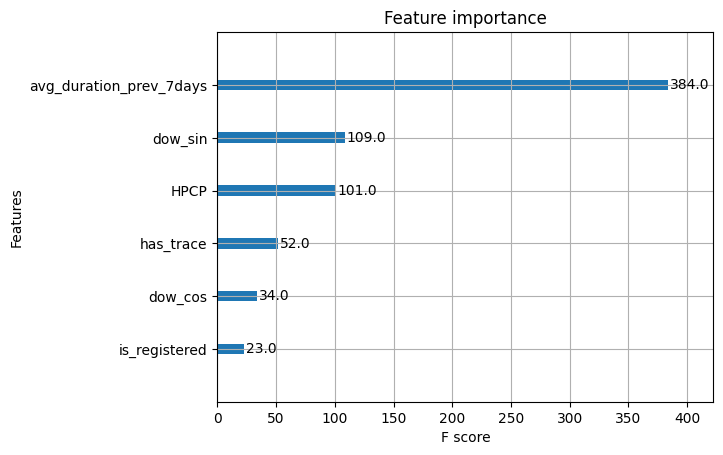

In [19]:
from xgboost import plot_importance

# Plot feature importance
ax = plot_importance(regressor_xgb_opt, importance_type='weight')  # or 'gain', 'cover'

map_features = {f'f{ii}': col for ii, col in enumerate(cols_features)}

y_labels_new = []
for label in ax.get_yticklabels():
    label.set_text(map_features[label.get_text()])
    y_labels_new.append(label)
ax.set_yticklabels(y_labels_new)

# Save best model

In [20]:
import joblib
joblib.dump(model_xgb_opt, PATH_TO_RES/"trip-duration-predictor.joblib")

['/Users/salvatoremaraniello/git/bikehub-model/studies/results/trip-duration-predictor.joblib']

In [21]:
# Test loading the model and generationg a forecast
model = joblib.load(PATH_TO_RES/"trip-duration-predictor.joblib")

payload_dict = {
    'avg_duration_prev_7days': 13.2,
    'HPCP': 0.1,
    'is_registered': 0.0,
    'dow_sin': 0.78,
    'dow_cos': 0.62,
    'has_trace': 1.0
}

model.predict(pd.DataFrame([payload_dict])[cols_features])

array([12.505909], dtype=float32)